In [1]:
#!pip install folium
#!pip install requests
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn


In [2]:
import folium
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# “Cold Start” - Restaurants Recommendation Location-Based


##### This project presents a solution to the user cold-start problem in recommender systems by implementing geographic clustering methods on Yelp restaurant data.
##### The "cold-start" problem, is where new users without prior activity or preferences pose a challenge in delivering personalized and relevant recommendations. Traditional approaches relying on
##### historical data fall short for these users, emphasizing the need for innovative solutions. Our project aims to address this issue using geospatial data available within Yelp's extensive collection ##### of restaurant information.
##### We will examine 3 clustering methods:K-Means Clustering, DBSCAN and Hierarchical Clustering and use them as a basis for creating location-based recommendations.

### Collecting Data

##### API KEY= to try this code you will need to inser your API KEY from Yelp. for help: https://docs.developer.yelp.com/docs/getting-started.
The Search API endpoint returns up to 1,000 results from the original query and up to 50 results per individual Search API request. Hence, we used an offset parameter to get the next page of results.
To use the offset parameter, if is specified limit=50 we'll get results 1 through 50. Further, if is specified offset=51 we'll get results 51 through 100. 
##### Specific location - Texas.
- Due to the restrictions on the amount of data entries we could retrieve, we chose to concentrate on collecting information from a single city - Texas.
This approach allowed us to gather a data set that was both extensive and relevant to our project's needs.
- we chose to focus on Texas because we think it has strategic advantages:
Texas has one of the largest and fastest-growing economies in the U.S., providing business opportunities across a range of sectors.
With a mix of urban and rural areas and a culturally rich demographic, Texas offers a varied market for consumers.


In [3]:
# empty list to place our data for each page
lst = []
API_KEY = "Enter Your API Key"
# our offset parameter - each page 50 rows
offset = 0
print('initial offset number: {}'.format(offset))

# loop through the api 20 times (limit is 1000 rows with each page includes 50 rows)
for i in range(20):
    
    try:
        headers = {'Authorization': 'Bearer {}'.format(API_KEY)}
        search_api_url = 'https://api.yelp.com/v3/businesses/search'
        params = {'term': 'food', 
                  'categories': 'restaurants',
                  'location': 'Texas', #If we will change here we can do the project on a different city
                  'offset': offset,
                  'limit': 50}

        response = requests.get(search_api_url, 
                                headers=headers, 
                                params=params, 
                                timeout=10)

        # return a dictionary
        data_dict = response.json()
        
        # convert the business dictionary to a pandas dataframe and append to list
        data = pd.DataFrame(data_dict['businesses'])
        lst.append(data)
      
        # add 50 to the offset to access a new page
        offset += 50
        print('current offset number: {}'.format(offset))
        
    except Exception as ex:
        print('exception: {}\nexit loop.'.format(ex))
        break

# concatenate all pages to one dataframe and reset index
df = pd.concat(lst)
df = df.reset_index(drop=True)

# review shape of dataframe
rows, columns = df.shape
print()
print('query includes {:,} rows and {} columns.'.format(rows, columns))
print('row id is unique: {}.'.format(df['id'].is_unique))

# review if dataframe id is unique, if not drop duplicates
if df['id'].is_unique == False:
    duplicates = df.loc[df.duplicated(subset=['id'])]
    vals = list(duplicates.head()['name'].values)
    print('\nduplicates found: {}.'.format(vals))
    
    df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
    print('dropping duplicates...')
    
    rows, columns = df.shape
    print('\nrow id is unique: {}.'.format(df['id'].is_unique))
    print('query includes {:,} rows and {} columns.'.format(rows, columns))



initial offset number: 0
current offset number: 50
current offset number: 100
current offset number: 150
current offset number: 200
current offset number: 250
current offset number: 300
current offset number: 350
current offset number: 400
current offset number: 450
current offset number: 500
current offset number: 550
current offset number: 600
current offset number: 650
current offset number: 700
current offset number: 750
current offset number: 800
current offset number: 850
current offset number: 900
current offset number: 950
current offset number: 1000

query includes 1,000 rows and 16 columns.
row id is unique: False.

duplicates found: ["Lucille's", "Puebla's Mexican Kitchen", 'Tiny Champions', 'Grace Pizza and Shakes', "Layne's Chicken Fingers"].
dropping duplicates...

row id is unique: True.
query includes 812 rows and 16 columns.


In [4]:
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,location,phone,display_phone,distance,price
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"{'latitude': 29.73843, 'longitude': -95.38048}","[pickup, delivery]","{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,NaN
1,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"{'latitude': 29.7634662971423, 'longitude': -9...","[pickup, delivery]","{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,NaN
2,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"{'latitude': 29.7623351, 'longitude': -95.3630...","[restaurant_reservation, pickup, delivery]","{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,NaN
3,XDJPJlO7-ZrOQlJMz5W5Wg,clutch-city-burgers-houston-3,Clutch City Burgers,https://s3-media4.fl.yelpcdn.com/bphoto/cprjW7...,False,https://www.yelp.com/biz/clutch-city-burgers-h...,12,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.9,"{'latitude': 29.775491, 'longitude': -95.37214}",[],"{'address1': '2004 Houston Ave', 'address2': N...",+18324525574,(832) 452-5574,1817.399857,NaN
4,0-HP4KRhvLgMEEJ0gjqIIw,little-patagonia-houston-2,Little Patagonia,https://s3-media3.fl.yelpcdn.com/bphoto/kAYXvo...,False,https://www.yelp.com/biz/little-patagonia-hous...,43,"[{'alias': 'empanadas', 'title': 'Empanadas'},...",4.6,"{'latitude': 29.7387306, 'longitude': -95.4702...",[],"{'address1': '5393 Westheimer Rd', 'address2':...",+18328046905,(832) 804-6905,10985.268442,NaN


In [5]:
# Export DataFrame to CSV
df.to_csv("Yelp_Restaurant.csv",index=False)

### Pre Processing
#### Data preprocessing is a foundational task that enhances the quality and precision of the dataset, ensuring that the subsequent analysis is based on reliable and relevant information

##### - Creating columns of latitude and longitude from column "coordinates".

In [6]:
df[["latitude","longitude"]] = df["coordinates"].apply(pd.Series)
df = df.drop(columns=['coordinates'])
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,location,phone,display_phone,distance,price,latitude,longitude
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]","{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,NaN,29.738430,-95.380480
1,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]","{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,NaN,29.763466,-95.360690
2,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[restaurant_reservation, pickup, delivery]","{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,NaN,29.762335,-95.363033
3,XDJPJlO7-ZrOQlJMz5W5Wg,clutch-city-burgers-houston-3,Clutch City Burgers,https://s3-media4.fl.yelpcdn.com/bphoto/cprjW7...,False,https://www.yelp.com/biz/clutch-city-burgers-h...,12,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.9,[],"{'address1': '2004 Houston Ave', 'address2': N...",+18324525574,(832) 452-5574,1817.399857,NaN,29.775491,-95.372140
4,0-HP4KRhvLgMEEJ0gjqIIw,little-patagonia-houston-2,Little Patagonia,https://s3-media3.fl.yelpcdn.com/bphoto/kAYXvo...,False,https://www.yelp.com/biz/little-patagonia-hous...,43,"[{'alias': 'empanadas', 'title': 'Empanadas'},...",4.6,[],"{'address1': '5393 Westheimer Rd', 'address2':...",+18328046905,(832) 804-6905,10985.268442,NaN,29.738731,-95.470252


##### - For each branch of restaurant create column with the address (addresses are in column "location").

In [7]:
max_num_addresses = df['location'].apply(lambda x: len(x) if isinstance(x, dict) else 0).max()
for i in range(1, max_num_addresses + 1):
    col_name = f'address_{i}'
    df[col_name] = df['location'].apply(lambda x: x.get(f'address{i}', None) if isinstance(x, dict) else None)
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,latitude,longitude,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",...,29.738430,-95.380480,3711 Travis St,,,None,None,None,None,None
1,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]",...,29.763466,-95.360690,909 Franklin St,,,None,None,None,None,None
2,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[restaurant_reservation, pickup, delivery]",...,29.762335,-95.363033,415 Milam St,None,None,None,None,None,None,None
3,XDJPJlO7-ZrOQlJMz5W5Wg,clutch-city-burgers-houston-3,Clutch City Burgers,https://s3-media4.fl.yelpcdn.com/bphoto/cprjW7...,False,https://www.yelp.com/biz/clutch-city-burgers-h...,12,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.9,[],...,29.775491,-95.372140,2004 Houston Ave,None,,None,None,None,None,None
4,0-HP4KRhvLgMEEJ0gjqIIw,little-patagonia-houston-2,Little Patagonia,https://s3-media3.fl.yelpcdn.com/bphoto/kAYXvo...,False,https://www.yelp.com/biz/little-patagonia-hous...,43,"[{'alias': 'empanadas', 'title': 'Empanadas'},...",4.6,[],...,29.738731,-95.470252,5393 Westheimer Rd,Ste B,None,None,None,None,None,None


##### - Counting empty cells and treatment.

In [8]:
none_count = df.isna().sum()
print(none_count)

# Remove columns 'address_4', 'address_5', 'address_6', 'address_7', 'address_8' if they exist
columns_to_drop = [f'address_{i}' for i in range(4, 9)]
df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()

id                 0
alias              0
name               0
image_url          0
is_closed          0
url                0
review_count       0
categories         0
rating             0
transactions       0
location           0
phone              0
display_phone      0
distance           0
price            727
latitude           0
longitude          0
address_1          9
address_2        205
address_3        381
address_4        812
address_5        812
address_6        812
address_7        812
address_8        812
dtype: int64


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,location,phone,display_phone,distance,price,latitude,longitude,address_1,address_2,address_3
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,False,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]","{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,NaN,29.738430,-95.380480,3711 Travis St,,
1,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,False,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]","{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,NaN,29.763466,-95.360690,909 Franklin St,,
2,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,False,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[restaurant_reservation, pickup, delivery]","{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,NaN,29.762335,-95.363033,415 Milam St,None,None
3,XDJPJlO7-ZrOQlJMz5W5Wg,clutch-city-burgers-houston-3,Clutch City Burgers,https://s3-media4.fl.yelpcdn.com/bphoto/cprjW7...,False,https://www.yelp.com/biz/clutch-city-burgers-h...,12,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.9,[],"{'address1': '2004 Houston Ave', 'address2': N...",+18324525574,(832) 452-5574,1817.399857,NaN,29.775491,-95.372140,2004 Houston Ave,None,
4,0-HP4KRhvLgMEEJ0gjqIIw,little-patagonia-houston-2,Little Patagonia,https://s3-media3.fl.yelpcdn.com/bphoto/kAYXvo...,False,https://www.yelp.com/biz/little-patagonia-hous...,43,"[{'alias': 'empanadas', 'title': 'Empanadas'},...",4.6,[],"{'address1': '5393 Westheimer Rd', 'address2':...",+18328046905,(832) 804-6905,10985.268442,NaN,29.738731,-95.470252,5393 Westheimer Rd,Ste B,None


##### - Validate only open restaurants will show.

In [9]:
df.dtypes
df['is_closed'] = (df['is_closed'] == False).astype(int)
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,location,phone,display_phone,distance,price,latitude,longitude,address_1,address_2,address_3
0,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,1,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]","{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,NaN,29.738430,-95.380480,3711 Travis St,,
1,xdx57Qj1FJi0MK8kwzbeuA,la-calle-tacos-houston-16,La Calle Tacos,https://s3-media4.fl.yelpcdn.com/bphoto/kBz7FT...,1,https://www.yelp.com/biz/la-calle-tacos-housto...,1153,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.0,"[pickup, delivery]","{'address1': '909 Franklin St', 'address2': ''...",+18327358226,(832) 735-8226,86.248358,NaN,29.763466,-95.360690,909 Franklin St,,
2,MuqrcFUxtovR-0Z4rlSwwg,space-city-birria-houston,Space City Birria,https://s3-media2.fl.yelpcdn.com/bphoto/V3Uh6j...,1,https://www.yelp.com/biz/space-city-birria-hou...,177,"[{'alias': 'tacos', 'title': 'Tacos'}, {'alias...",4.6,"[restaurant_reservation, pickup, delivery]","{'address1': '415 Milam St', 'address2': None,...",+18328027333,(832) 802-7333,355.968253,NaN,29.762335,-95.363033,415 Milam St,None,None
3,XDJPJlO7-ZrOQlJMz5W5Wg,clutch-city-burgers-houston-3,Clutch City Burgers,https://s3-media4.fl.yelpcdn.com/bphoto/cprjW7...,1,https://www.yelp.com/biz/clutch-city-burgers-h...,12,"[{'alias': 'halal', 'title': 'Halal'}, {'alias...",4.9,[],"{'address1': '2004 Houston Ave', 'address2': N...",+18324525574,(832) 452-5574,1817.399857,NaN,29.775491,-95.372140,2004 Houston Ave,None,
4,0-HP4KRhvLgMEEJ0gjqIIw,little-patagonia-houston-2,Little Patagonia,https://s3-media3.fl.yelpcdn.com/bphoto/kAYXvo...,1,https://www.yelp.com/biz/little-patagonia-hous...,43,"[{'alias': 'empanadas', 'title': 'Empanadas'},...",4.6,[],"{'address1': '5393 Westheimer Rd', 'address2':...",+18328046905,(832) 804-6905,10985.268442,NaN,29.738731,-95.470252,5393 Westheimer Rd,Ste B,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,1xZ2_Wy3hDJ7py2Ny6Otdg,colwells-bbq-soul-food-and-more-houston-2,Colwell's BBQ/Soul Food and More,https://s3-media4.fl.yelpcdn.com/bphoto/1ZtLuK...,1,https://www.yelp.com/biz/colwells-bbq-soul-foo...,15,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",3.8,"[delivery, pickup]","{'address1': '9230 A Jensen Dr', 'address2': '...",+12818889876,(281) 888-9876,9384.064893,NaN,29.846000,-95.342440,9230 A Jensen Dr,,
808,EO5UTVEGq6Fo32pQi3h-Mg,mels-germarican-imbiss-la-porte,Mels Germarican Imbiss,https://s3-media3.fl.yelpcdn.com/bphoto/1WPohD...,1,https://www.yelp.com/biz/mels-germarican-imbis...,2,"[{'alias': 'newamerican', 'title': 'New Americ...",5.0,[],"{'address1': '1201 S 16th St', 'address2': Non...",+18327666142,(832) 766-6142,33763.786819,NaN,29.650559,-95.035271,1201 S 16th St,None,None
809,d_BLF5bq4-HBxkJ14ps7YQ,the-general-public-houston,The General Public,https://s3-media2.fl.yelpcdn.com/bphoto/LTceXa...,1,https://www.yelp.com/biz/the-general-public-ho...,776,"[{'alias': 'newamerican', 'title': 'New Americ...",4.0,[delivery],"{'address1': '797 Sorella Ct', 'address2': 'St...",+18326904450,(832) 690-4450,19565.394009,NaN,29.778939,-95.561835,797 Sorella Ct,Ste 118,None
810,ZUOpS8RA4Br6qUMCi7arcQ,backyard-boil-house-houston,Backyard Boil House,https://s3-media4.fl.yelpcdn.com/bphoto/J2dXkM...,1,https://www.yelp.com/biz/backyard-boil-house-h...,60,"[{'alias': 'seafood', 'title': 'Seafood'}, {'a...",4.7,"[delivery, pickup]","{'address1': '3755 Southmore Blvd', 'address2'...",+18323470821,(832) 347-0821,5714.674044,NaN,29.711745,-95.356004,3755 Southmore Blvd,,None


### Visualizations
#### Data visualization during preprocessing is essential for quickly spotting trends, anomalies, and inconsistencies.

##### - Show the best restaurants in Texas.

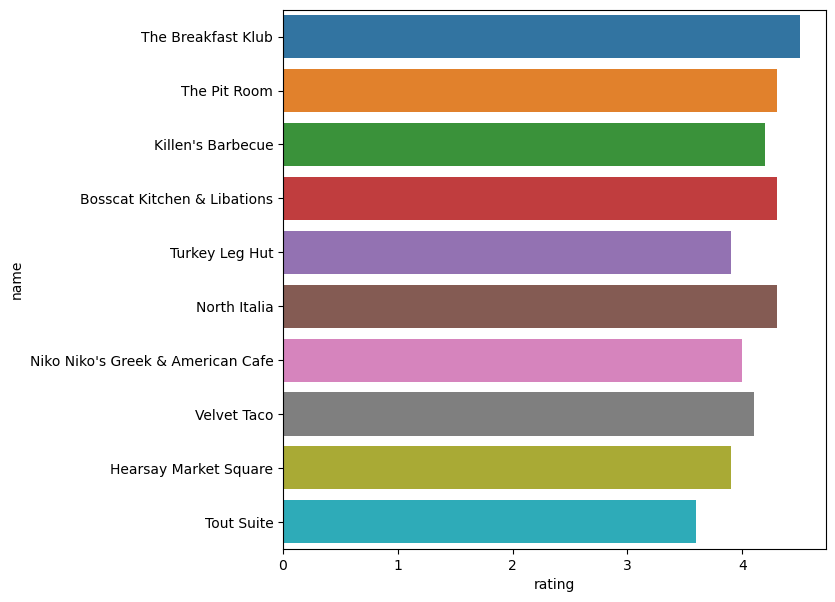

In [10]:
top_restaurants = df.sort_values(by=['review_count', 'rating'], ascending=False)[:10]
fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(x = 'rating', y = 'name', data=top_restaurants, ax= ax)
plt.show()

##### - Show the relationship between rating & number of reviews.

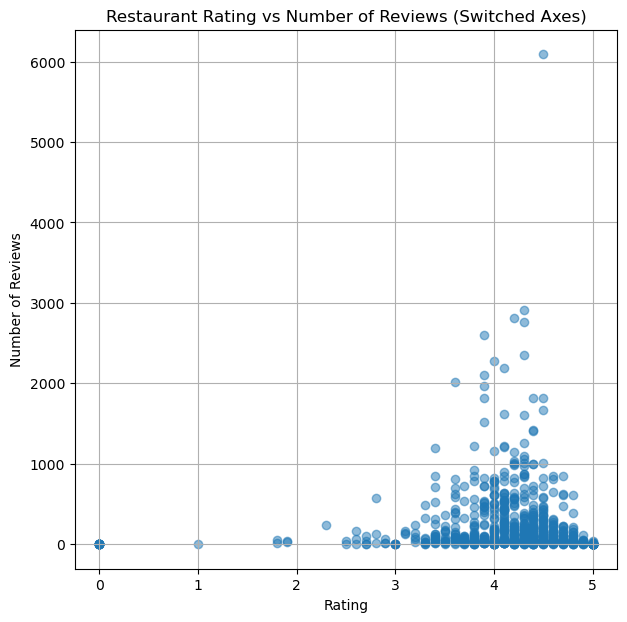

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(df['rating'], df['review_count'], alpha=0.5)  # Switched x and y variables
plt.title('Restaurant Rating vs Number of Reviews (Switched Axes)')
plt.xlabel('Rating')  # Rating on the x-axis
plt.ylabel('Number of Reviews')  # Number of reviews on the y-axis
plt.grid(True)
plt.show()


most restaurants have max 2000 reviews.
lets zoom-in an:

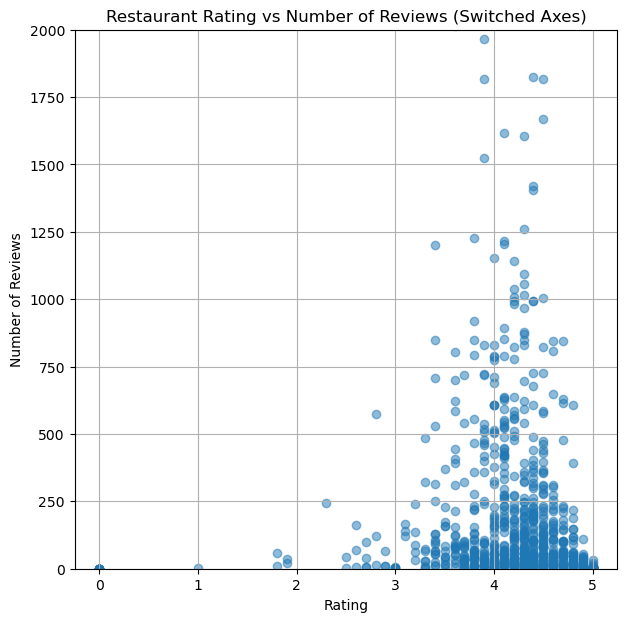

In [12]:
plt.figure(figsize=(7, 7))
plt.scatter(df['rating'], df['review_count'], alpha=0.5)  # Switched x and y variables
plt.title('Restaurant Rating vs Number of Reviews (Switched Axes)')
plt.xlabel('Rating')  # Rating on the x-axis
plt.ylabel('Number of Reviews')  # Number of reviews on the y-axis
plt.grid(True)
# Set x-axis limits to 0-1500
plt.ylim(0, 2000)
plt.show()

- Most of the restaurants' rating are 3.5-5, and with top of 250 reviews - suggesting a trend towards higher customer satisfaction.
- There are also restaurands with more reviews, and most of them have rating around 4 - indicating that establishments with greater review counts often deliver quality experiences consistently enough to maintain a high rating.

##### - Show the restaurant rating distribution.

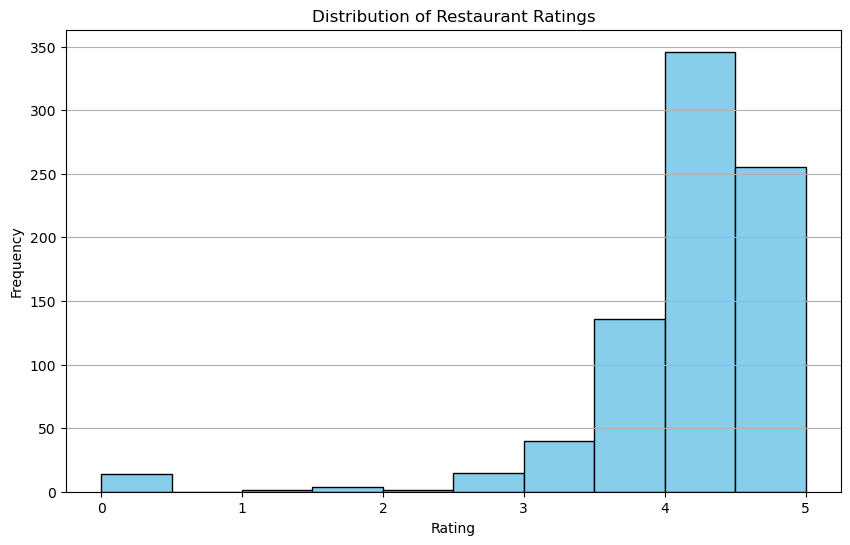

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

- There are more rating of 4 than 5 - suggesting that while customers are generally satisfied, they may reserve the highest rating for exceptional experiences.
- It is not common to rate if its not 3+ - implies that customers are less likely to rate their experience unless it meets a baseline level of satisfaction.

##### - Show the restaurant dennsity & rating by location.

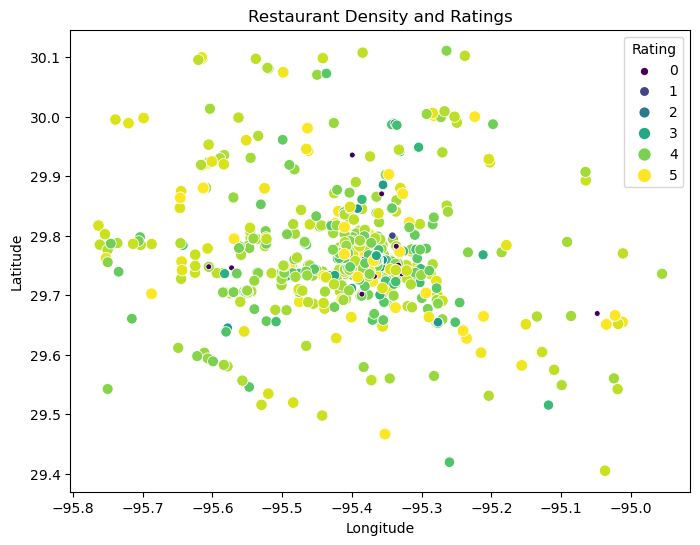

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', size='rating', data=df, hue='rating', palette='viridis')
plt.title('Restaurant Density and Ratings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Rating')
plt.show()

- Most of the restaurants locate in the range- lat: (29.7-29.8), lon: (-95.6,-95.3) - Houston in texas is a significant urban center.
- As shows in the other graph also here we can see the common rating of 4 and 5.
- most of the low rating are in the center (where is the most restaurants located) - could imply that competition is stiffer, or that quality may vary more significantly where restaurant options are abundant.

### Clustering & Recommendation Models
##### We propose a geospatial clustering approach, using: K-means clustering, DBSCAN and hierarchical clustering.
##### For each clustering method we will exam the Silhouette Score to asses the model.
##### This clusters will be a foundation for delivering recommendations to users.
##### Experimental framework:
- valuate the models's accuracy in clustering restaurants geographically.
- assess the system's effectiveness at recommending high-rated restaurants within these clusters.
- measure the speed at which these recommendations are generated.

#### Create Case-Study data to exam the models

In [15]:
test = {
    'longitude': [],
    'latitude': []
}
# Fixing longitude and latitude values
test['longitude'] = [29.7137]
test['latitude'] = [-95.3892]
# Creating DataFrame
user = pd.DataFrame(test)
user

,longitude,latitude
0,29.7137,-95.3892


#### K-Means Clustering

In [16]:
#Finding the optimal K for KNN
coords = df[['longitude','latitude']]
distortions = []
for k in range(1,25):
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

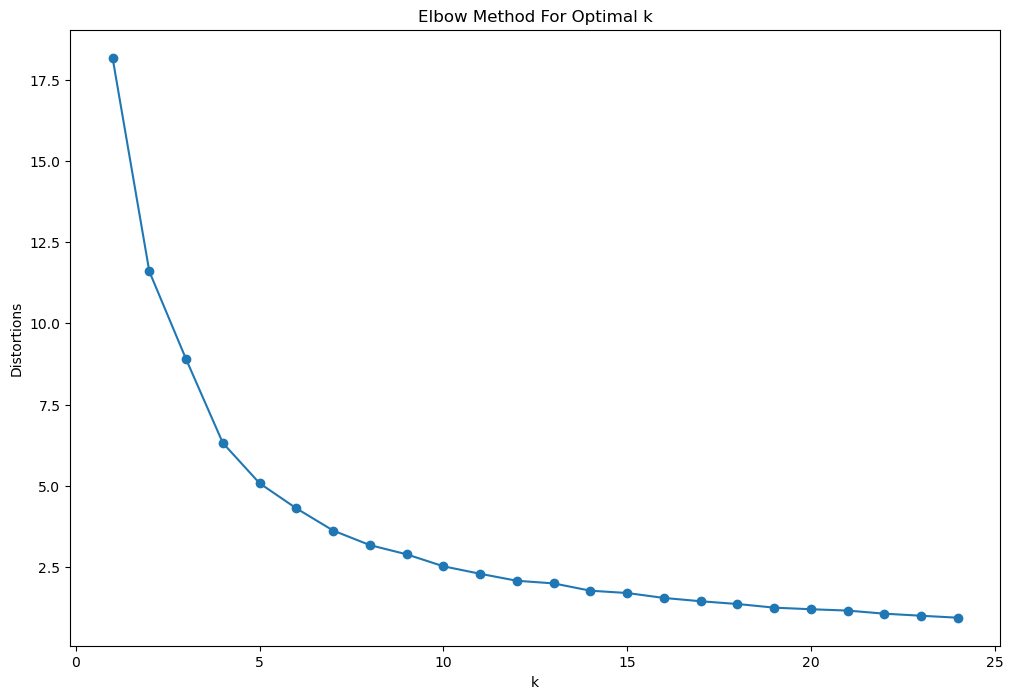

In [17]:
#Searching for the optimal K using the elbow method
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
sil = []
kmax = 25
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [19]:
sil

[0.4739929886531098,
 0.5018648748406013,
 0.5356799510333675,
 0.5374133188951751,
 0.5023815835785413,
 0.4733122013969433,
 0.4423294713707211,
 0.42331242146598075,
 0.42783371556725575,
 0.4164336309703304,
 0.41330477507058716,
 0.3869492160945233,
 0.4087857641552927,
 0.41616904015484474,
 0.3811684902207558,
 0.41845788305662435,
 0.41947087724931925,
 0.42419387206391496,
 0.42208658580370473,
 0.425241742678956,
 0.42490272983467814,
 0.4130780801825445,
 0.41059000086766667,
 0.4258191684450152]

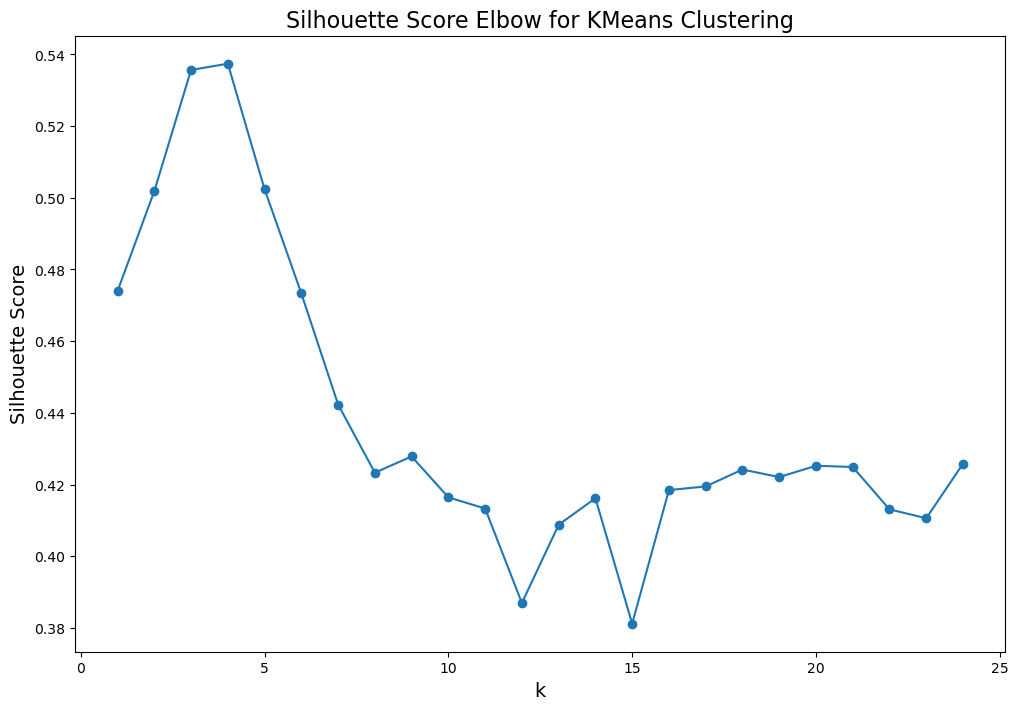

In [20]:
# Elbow Graph for Silhouette Score
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), sil[:24], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 4  silhouette_score  0.5356799510333675


In [22]:
df['cluster'] = kmeans.predict(df[['longitude','latitude']])

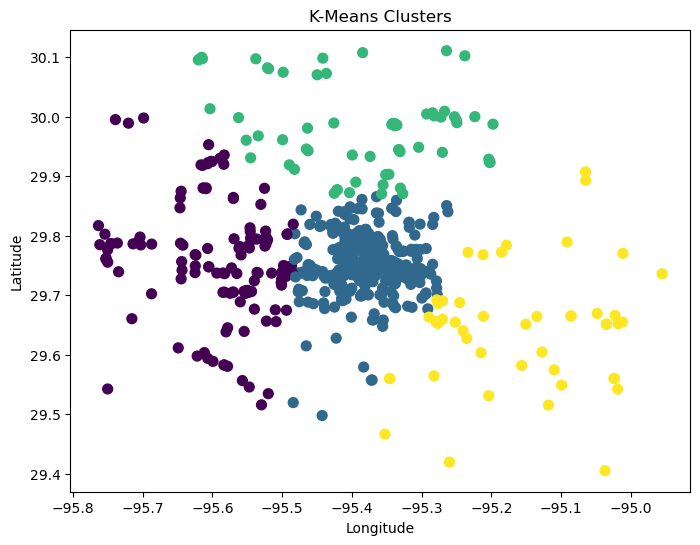

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', marker='o', s=50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusters')
plt.show()

In [24]:
def recommend_restaurants_k(df, longitude, latitude):
    start = time.time()
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("Cluster:", cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    # Get the best restaurant in this cluster
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','rating']]

#### K-Means - Exam User Test

In [25]:
#user test
user1_test=recommend_restaurants_k(df, user.longitude, user.latitude)
user1_test

Cluster: 3
Time until getting a result:  0.11296916007995605


,name,latitude,longitude,rating
26,The Cuban Cafe,29.654470,-95.012010,4.9
35,Broke Da Mouth Treats,29.530695,-95.203793,4.4
107,Chicharrones El Guero,29.771840,-95.233550,4.1
165,Killen's Barbecue,29.564033,-95.282281,4.2
175,The Cuban Cafe - Baytown,29.770007,-95.011461,4.5
180,Asha's Roti Shop,29.735680,-94.955320,4.3
181,Antone’s Famous Po Boys,29.654582,-95.279335,4.0
182,Str Eat,29.655107,-95.279091,1.9
200,Velvet Taco,29.654424,-95.276578,3.8
215,Noodle Master,29.663942,-95.134692,4.4


In [26]:
# Create a map centered at a specific location
map_center = [29.7137, -95.3892]  # Latitude and longitude of Houston, Texas
my_map = folium.Map(location=map_center, zoom_start=12, width=800, height=600)

# Add a red marker at the same location
folium.Marker(
    location=map_center,
    popup='Center (Red)',
    icon=folium.Icon(color='red')
).add_to(my_map)

# Add markers to the map for each location from user reccomondation
for index, row in user1_test.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(my_map)

# Display the map
my_map

#### DBSCAN

In [27]:
# Select relevant features for clustering
X = df[['rating','latitude', 'longitude']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
df['cluster'] = dbscan.fit_predict(X_scaled)

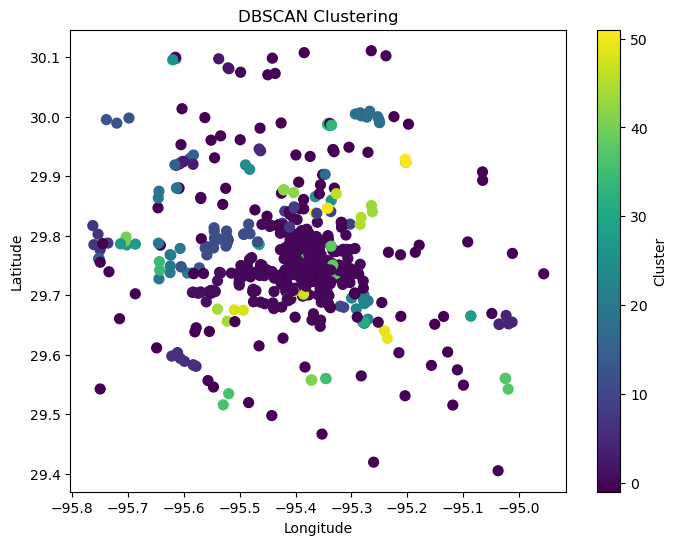

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', marker='o', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

In [29]:
def calculate_silhouette_score(df, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df)
    silhouette = silhouette_score(df, labels)
    return silhouette

X = df[['rating', 'latitude', 'longitude']]
calculate_silhouette_score(X, 0.3, 2)

0.72886379081956

In [30]:
def recommend_restaurants_db(df, longitude, latitude):
    #Predict the cluster for longitude and latitude provided
    start =time.time()
    cluster = dbscan.fit_predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("Cluster:", cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    #Get the best restaurant in this cluster
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','rating']]

#### Exam User Test

In [31]:
#test
user_text_db=recommend_restaurants_db(df, user.longitude, user.latitude)
user_text_db

Cluster: -1
Time until getting a result:  0.0019941329956054688


,name,latitude,longitude,rating
19,House of Fries,29.843105,-95.472766,4.5
34,AZTECA Taco House,29.879736,-95.330429,4.7
35,Broke Da Mouth Treats,29.530695,-95.203793,4.4
59,Red’s Kitchen,29.647412,-95.355838,4.8
93,Porky's Backyard,29.987229,-95.197699,3.9
96,Cabo Bobs Burritos - Houston,29.967554,-95.534231,4.4
107,Chicharrones El Guero,29.771840,-95.233550,4.1
117,Bamboo House,29.939870,-95.270260,4.4
165,Killen's Barbecue,29.564033,-95.282281,4.2
166,TJ Filipino Cuisine,29.578951,-95.383058,4.2


In [32]:
# Create a map centered at a specific location
map_center = [29.7137, -95.3892]  # Latitude and longitude of Houston, Texas
my_map = folium.Map(location=map_center, zoom_start=10, width=800, height=600)
# Add a red marker at the same location
folium.Marker(
    location=map_center,
    popup='Center (Red)',
    icon=folium.Icon(color='red')
).add_to(my_map)

# Add markers to the map for each location from user reccomondation
for index, row in user_text_db.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(my_map)

# Display the map
my_map

#### Hierarchical Clustering

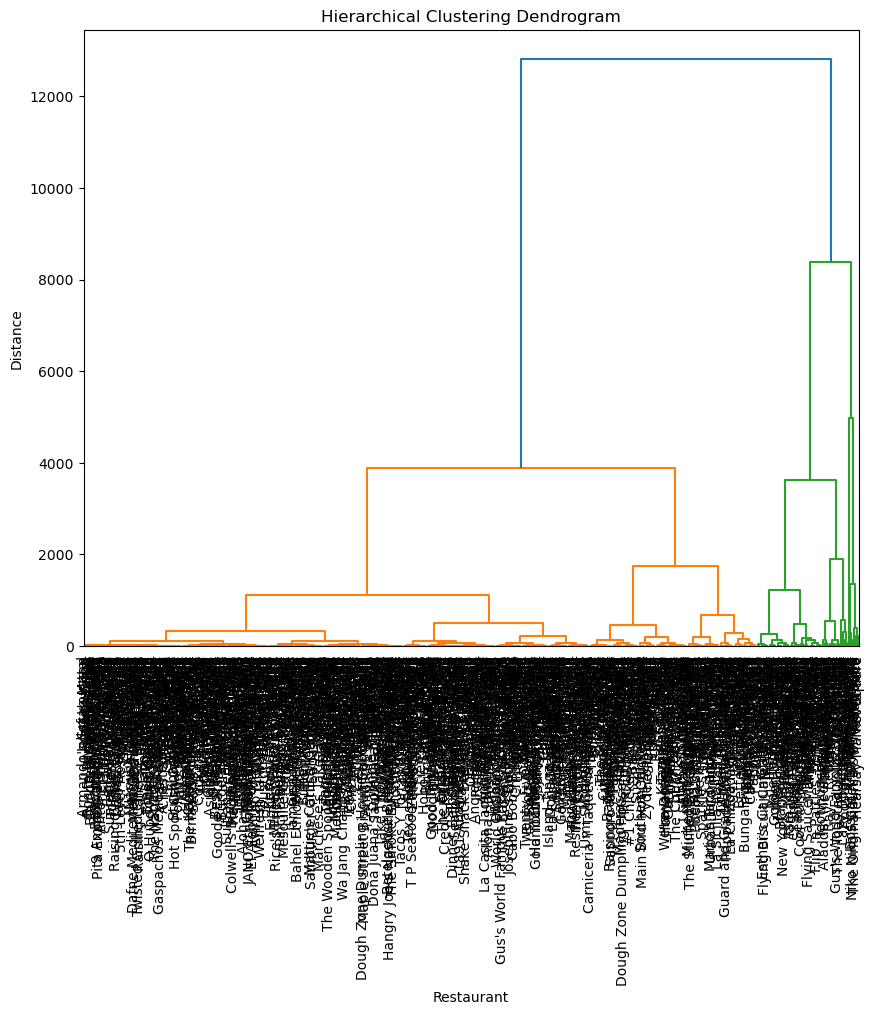

In [33]:
# Select relevant features for clustering
X = df[['rating', 'review_count', 'longitude', 'latitude']]

# Perform hierarchical clustering
Z = linkage(X, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=df['name'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Restaurant')
plt.ylabel('Distance')
plt.show()


In [34]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist

def predict_location_cluster(locations, new_location, k=3):
   
    # Select relevant features for clustering
    X = locations[['latitude', 'longitude']].to_numpy()

    # Perform hierarchical clustering (Ward minimizes the sum of squared differences within all clusters).
    Z = linkage(X, method='ward')
    
    start =time.time()
    # Assign clusters to data points
    clusters = fcluster(Z, k, criterion='maxclust')
    
    # Calculate distances to cluster centroids
    centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(1, k+1)])
    distances = cdist(np.array([new_location]), centroids)

    silhoette_avg = silhouette_score(X, clusters)
    print("The silhouette score is: ", silhoette_avg)
    
    # Predict cluster for new location
    predicted_cluster = np.argmin(distances) + 1  # +1 because cluster indexing starts from 1
    end = time.time()
    print("Time until getting a result: ", end - start)
    
    #plot the cluster
    plt.figure(figsize=(8, 6))
    plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', marker='o', s=50)
    plt.title('Hierarchical Clustering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Cluster')
    plt.show()


    return predicted_cluster

#### Exam User Test

In [35]:
user = [29.7137, -95.3892]

The silhouette score is:  0.48058988134042374
Time until getting a result:  0.05108785629272461


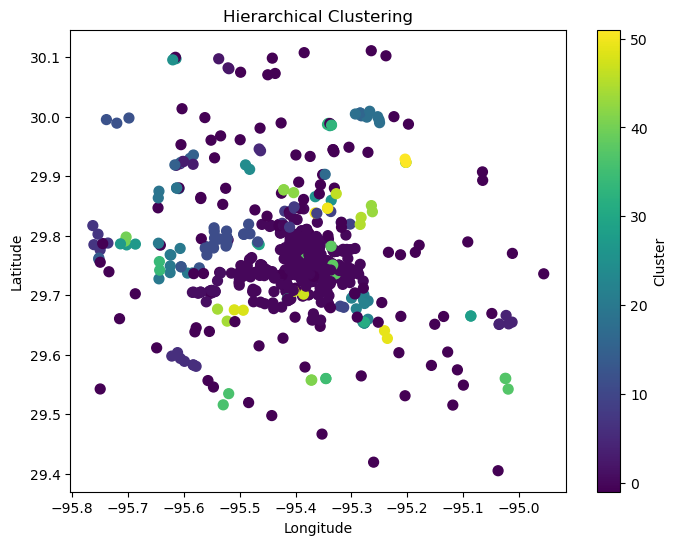

Cluster: 3


,name,latitude,longitude,rating
25,Aloha Hawaiian BBQ Express,29.924630,-95.601935,4.7
475,Crimson Crab,29.924437,-95.600505,4.8
142,Chronic Fries,29.920770,-95.606760,4.7
755,Steady Snack’n,29.919772,-95.583535,4.7
378,Überrito,29.917980,-95.613900,5.0


In [36]:
# test user
predicted_cluster = predict_location_cluster(df, user)
print("Cluster:", predicted_cluster)

suggest_cl = df[df["cluster"] == predicted_cluster].sort_values(by=['review_count', 'rating'], ascending=False).iloc[:10][['name', 'latitude','longitude','rating']]
suggest_cl

In [37]:
# Create a map centered at a specific location
map_center = [29.7137, -95.3892]  # Latitude and longitude of Houston, Texas
my_map = folium.Map(location=map_center, zoom_start=12, width=800, height=600)
# Add a red marker at the same location
folium.Marker(
    location=map_center,
    popup='Center (Red)',
    icon=folium.Icon(color='red')
).add_to(my_map)

# Add markers to the map for each location from user recommendation.
for index, row in suggest_cl.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(my_map)

# Display the map
my_map

In [38]:
#!pip freeze > requirements.txt